[View in Colaboratory](https://colab.research.google.com/github/hyunjinb/generative_models/blob/master/mnist_VAE_practice.ipynb)

**Variational Autoencoder Practice v0.1** Hyun-Jin Bae

main references: 

1) https://gist.github.com/tushuhei/380f75c2e0db35b24a48f7dd7b898bb1

2) https://blog.keras.io/building-autoencoders-in-keras.html

In [0]:
import numpy as np

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras import objectives
from matplotlib import pyplot as plt

%matplotlib inline

In [0]:
image_size = 28
original_dim = image_size * image_size
latent_dim = 2
intermediate_dim = 128
batch_size = 256
epochs = 100
epsilon_std = 1.0

In [115]:
#load MNIST data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [0]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_std) * epsilon

In [0]:
def vae_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.square(x - x_decoded_mean), axis=-1), axis=-1)
    #xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss

In [0]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_std])

decoder_h1 = Dense(intermediate_dim, activation='relu')
decoder_h2 = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h1_decoded = decoder_h1(z)
h2_decoded = decoder_h2(h1_decoded)
x_decoded_mean = decoder_mean(h2_decoded)

In [0]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h1_decoded = decoder_h1(decoder_input)
_h2_decoded = decoder_h2(_h1_decoded)
_x_decoded_mean = decoder_mean(_h2_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [0]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [121]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 128)          100480      input_14[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 128)          16512       dense_48[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 2)            258         dense_49[0][0]                   
__________________________________________________________________________________________________
dense_51 (

In [122]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=100,
        batch_size=256,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 52us/step - loss: 57.5249 - val_loss: 48.1265
Epoch 2/100
60000/60000 [==============================] - 2s 37us/step - loss: 46.2325 - val_loss: 44.3538
Epoch 3/100
60000/60000 [==============================] - 2s 37us/step - loss: 42.7736 - val_loss: 41.2771
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 41.1528 - val_loss: 40.4417
Epoch 5/100
60000/60000 [==============================] - 2s 37us/step - loss: 40.2144 - val_loss: 39.9132
Epoch 6/100
60000/60000 [==============================] - 2s 36us/step - loss: 39.3570 - val_loss: 38.7519
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 38.6129 - val_loss: 38.2186
Epoch 8/100
60000/60000 [==============================] - 2s 37us/step - loss: 37.9428 - val_loss: 37.5406
Epoch 9/100
60000/60000 [==============================] - 2s 37us/step - loss: 37.371

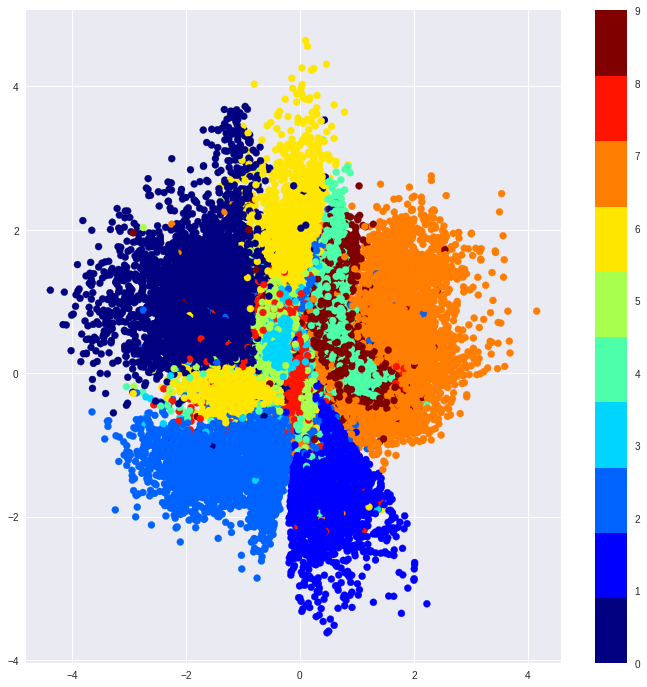

In [134]:
x_train_encoded = encoder.predict(x_train, batch_size=256)
plt.figure(figsize=(12, 12))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar()
plt.show()

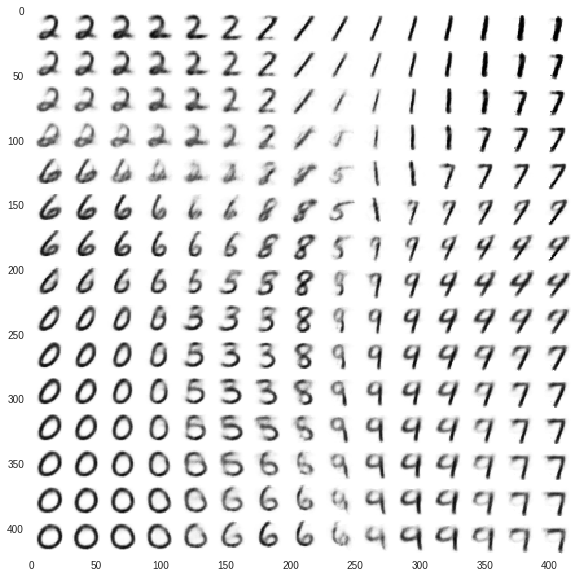

In [135]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1.5, 1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.grid(b=None)
plt.show()